In [2]:
import numpy as np
from numpy import exp, pi, cos, sqrt, arcsin
import matplotlib.pyplot as plt
from control import tf
# from matplotlib.widgets import Slider, Button, RadioButtons

In [21]:
c = 3e8

class Cavity:
    def __init__(self, L, r=(0.8, 1), t=(0.2, 0)):
        r = np.array(r)
        t = np.array(t)
        
        if (r**2 + t**2 > 1).any :
            raise ValueError("The square sum of relection coef"
                             "and transmission coef should be less than 1.")
            
        self.loss = False
        self.cavity_length = L
        self.reflection_coef = r
        self.transmssion_coef = t
#         self.input_wavelength = lamda # nm
#         self.input_freq = c / self.input_wavelength / 1e-9
    
    def lossless(self, freq):
        r1, r2 = self.reflection_coef
        t1, t2 = self.transmssion_coef
        L = self.cavity_length
        self.freq = freq
        k = 2*pi*self.freq/c
        self.tf = -t1*t2*exp(-1j * k*L) / (1 - r1*r2*exp(-2j *k*L)) 
        self.circ_power = t1**2/(1 + r1**2 * r2**2 - 2*r1*r2*cos(2*k*L))
        self.reflected = (r1 - r2*(r1**2 + t1**2)*exp(-2j*k*L))/(1 - r1*r2*exp(-2j*k*L))
        
        self.fsr = c/2/L
        self.linewidth = 2*self.fsr/pi*arcsin((1 - r1*r2)/(2*sqrt(r1*r2)))
        self.finesse = pi/2/arcsin((1 - r1*r2)/(2*sqrt(r1*r2)))
        
    def plot(self):
        plt.figure(figsize=(8,6))
        
        plt.subplot(211)
        plt.title("cavity length = {}m".format(self.cavity_length))
        plt.plot(self.freq/1e3, np.abs(self.tf), label='transmitted')
        plt.plot(self.freq/1e3, np.abs(self.reflected), label='reflected')
        plt.plot(self.freq/1e3, sqrt(self.circ_power), label='circulating') 
        plt.ylabel("Field amplitude")
        plt.legend()
        plt.subplot(212)
        plt.plot(self.freq/1e3, np.angle(self.tf), label='transmitted')
        plt.plot(self.freq/1e3, np.angle(self.reflected), label='reflected')
        plt.plot(self.freq/1e3, np.angle(sqrt(self.circ_power)), label='circulating')
        plt.xlabel("frequency [kHZ]")
        plt.ylabel("phase [rad]")
        plt.show()
        
    

In [22]:
cavity = Cavity(10, (1, 1.1), (0 ,0))

ValueError: The square sum of relection coefand transmission coef should be less than 1

finesse: 103.8359


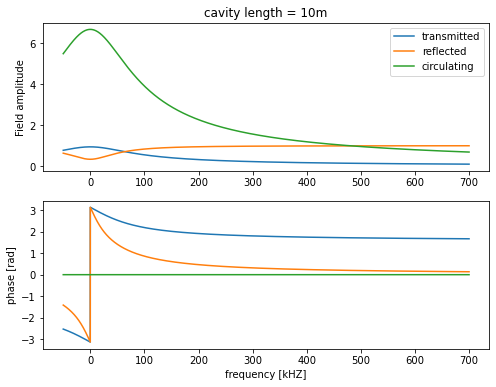

In [4]:
if __name__ == '__main__':
    n1 = 1
    n2 = 15
    r1 = abs(n1 - n2)/ (n1 + n2); r2 = abs(n2 - n1)/(n1 + n2)
    r = [0.98, 0.99]

    cavity = Cavity(10, r)
    freq = np.linspace(-50, 700, num=10000) * 1e3
    cavity.lossless(freq)
    print("finesse: {:.4f}".format(cavity.finesse))
    cavity.plot()